# Dimension-wise Class Activation Map (dCAM)



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_900689/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import sys
from torch.utils import data
import torch
from torch.autograd import Variable

In [3]:
sys.path.insert(0, '../src/models')
from CNN_models import ConvNet2D, ModelCNN, TSDataset
sys.path.insert(0, '../src/explanation')
from DCAM import DCAM

## Functions for synthetic dataset construction
### Parameters

In [4]:
# Number of instance of Class 1 to concatenate on each dimension
nb_seq = 5
# Number of dimensions (channels)
nb_dim = 8
# Number of instance per class
nb_instance = 200
# train-test ratio
train_test_r = 0.75

### Functions

In [5]:
def generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_set=None,side=0):
    """
    Generate a sequence with an anomaly injected at a random or specified position.

    Parameters
    ----------
    nb_seq : int
        Number of sequences to generate.
    all_class_1 : list
        List of normal class sequences.
    all_class_2 : list
        List of anomalous class sequences.
    pos_anom_set : int or None, optional
        Position to inject the anomaly. If None, a random position is chosen.
    side : int, optional
        Determines the side or type of anomaly injection (default is 0).

    Returns
    -------
    list
        Generated sequence with anomaly injected.
    """
    result = []
    rand_side = side
    if pos_anom_set is not None:
        pos_anom = pos_anom_set
    else:
        pos_anom = randint(0,nb_seq-1)
    for i in range(nb_seq):
        if i == pos_anom:
            if rand_side == 1:
                result += list(np.array(all_class_2[randint(0,len(all_class_2)-1)]))
            elif rand_side == 0:
                result += [cl2 for cl2 in all_class_2[randint(0,len(all_class_2)-1)]]
        else:
            result += all_class_1[randint(0,len(all_class_1)-1)]
    if side == 0:
        return [res for i,res in enumerate(result) if i % 15 == 0]
    else:
        return [res for i,res in enumerate(result) if i % 15 == 0]
        
def generate_normal(nb_seq,all_class_1,side=0):
    """
    Generate a normal sequence.

    Parameters
    ----------
    nb_seq : int
        Number of sequences to generate.
    all_class_1 : list
        List of normal class sequences.
    side : int, optional
        Determines the side or type of sequence generation (default is 0).

    Returns
    -------
    list
        Generated normal sequence.
    """
    result = []
    for i in range(nb_seq):
        result += all_class_1[randint(0,len(all_class_1)-1)]
    if side == 0:
        return [res for i,res in enumerate(result) if i % 15 == 0]
    else:
        return [res for i,res in enumerate(result) if i % 15 == 0]
        
def generate_multivaraite_norm(nb_dim,nb_seq,all_class_1):
    """
    Generate a multivariate normal instance.

    Parameters
    ----------
    nb_dim : int
        Number of dimensions (features).
    nb_seq : int
        Number of sequences to generate per dimension.
    all_class_1 : list
        List of normal class sequences.

    Returns
    -------
    tuple
        instance : list
            List of generated normal sequences for each dimension.
        list
            Empty list (placeholder for ground truth, not used here).
    """
    instance = []
    for i in range(nb_dim):
        instance.append(generate_normal(nb_seq,all_class_1,side = i%2))
    return instance,[]

def generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2,nb_k=2):
    """
    Generate a multivariate abnormal instance.

    Parameters
    ----------
    nb_dim : int
        Number of dimensions (features).
    nb_seq : int
        Number of sequences to generate per dimension.
    all_class_1 : list
        List of normal class sequences.
    all_class_2 : list
        List of anomalous class sequences.
    nb_k : int, optional
        Number of dimensions to inject anomalies (default is 2).

    Returns
    -------
    tuple
        instance : list
            List of generated sequences for each dimension, with anomalies injected in nb_k dimensions.
        groundtruth : list
            List of ground truth labels for each dimension, indicating anomaly positions.
    """
    instance = []
    all_rand_pos = []
    for i in range(nb_k):
        rand_pos = randint(0,nb_dim-1)
        while (rand_pos in all_rand_pos):
            rand_pos = randint(0,nb_dim-1)
        all_rand_pos.append(rand_pos)
    groundtruth = []
    all_pos_anom = []
    for i in range(nb_k):
        pos_anom = randint(0,nb_seq-1)
        while pos_anom in all_pos_anom: 
            pos_anom = randint(0,nb_seq-1)
        all_pos_anom.append(pos_anom)
    for i in range(nb_dim):
        found = False
        for rand_pos_2,pos_anom_2 in zip(all_rand_pos,all_pos_anom):
            if rand_pos_2 == i:
                instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side = i%2))#randint(0,1)))
                anom_length = len(all_class_1[0])//15 + 1
                groundtruth.append([0]*(anom_length*pos_anom_2) + [1]*anom_length + [0]*((nb_seq - pos_anom_2-1)*anom_length))
                found = True
                break
        if not found:
            instance.append(generate_normal(nb_seq,all_class_1,side = i%2))#randint(0,1)))
            groundtruth.append([0]*len(instance[-1]))
    return instance,groundtruth

def generate_multivaraite_abnormal_same(nb_dim,nb_seq,all_class_1,all_class_2):
    """
    Generate a multivariate abnormal instance with anomalies injected at the same positions across selected dimensions.

    Parameters
    ----------
    nb_dim : int
        Number of dimensions (features).
    nb_seq : int
        Number of sequences to generate per dimension.
    all_class_1 : list
        List of normal class sequences.
    all_class_2 : list
        List of anomalous class sequences.

    Returns
    -------
    list
        List of generated sequences for each dimension, with anomalies injected at the same positions in two selected dimensions.
    """
    instance = []
    rand_pos = 1#randint(0,nb_dim-1)
    rand_pos_2 = 8#randint(0,nb_dim-1)
    while (rand_pos_2 == rand_pos):
        rand_pos_2 = randint(0,nb_dim-1)
    pos_anom_1 = randint(0,nb_seq-1)
    pos_anom_2 = randint(0,nb_seq-1)
    while pos_anom_2 ==  pos_anom_1: 
        pos_anom_2 = randint(0,nb_seq-1)
    for i in range(nb_dim):
        if i == rand_pos:
            instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_1,side=0))
        elif rand_pos_2 == i:
            instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side=1))
        else:
            instance.append(generate_normal(nb_seq,all_class_1))
    return instance


def generate_multivaraite_abnormal_sync(nb_dim,nb_seq,all_class_1,all_class_2,nb_k=2):
    """
    Generate a multivariate abnormal instance with anomalies injected synchronously at the same position across selected dimensions.

    Parameters
    ----------
    nb_dim : int
        Number of dimensions (features).
    nb_seq : int
        Number of sequences to generate per dimension.
    all_class_1 : list
        List of normal class sequences.
    all_class_2 : list
        List of anomalous class sequences.
    nb_k : int, optional
        Number of dimensions to inject anomalies (default is 2).

    Returns
    -------
    tuple
        instance : list
            List of generated sequences for each dimension, with anomalies injected synchronously in nb_k dimensions.
        groundtruth : list
            List of ground truth labels for each dimension, indicating anomaly positions.
    """
    instance = []
    all_rand_pos = []
    for i in range(nb_k):
        rand_pos = randint(0,nb_dim-1)
        while (rand_pos in all_rand_pos):
            rand_pos = randint(0,nb_dim-1)
        all_rand_pos.append(rand_pos)
    groundtruth = []
    pos_anom_2 = randint(0,nb_seq-1)
    for i in range(nb_dim):
        found = False
        for rand_pos_2 in all_rand_pos:
            if rand_pos_2 == i:
                instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side = i%2))#randint(0,1)))
                anom_length = len(all_class_1[0])//15 + 1
                groundtruth.append([0]*(anom_length*pos_anom_2) + [1]*anom_length + [0]*((nb_seq - pos_anom_2-1)*anom_length))
                found = True
                break
        if not found:
            instance.append(generate_normal(nb_seq,all_class_1,side = i%2))#randint(0,1)))
            groundtruth.append([0]*len(instance[-1]))
    return instance,groundtruth

def gen_cube(instance):
    """
        Generate a cube structure from a given multivariate instance.

        Parameters
        ----------
        instance : list
            List of sequences (e.g., multivariate time series), where each element corresponds to a dimension.

        Returns
        -------
        list
            A cube structure (list of lists) where each sublist is a cyclic permutation of the input instance.
        """
    result = []
    for i in range(len(instance)):
        result.append([instance[(i+j)%len(instance)] for j in range(len(instance))])
    return result

def gen_line(instance):
    """
        Generate a line structure from a given multivariate instance.

        Parameters
        ----------
        instance : list
            List of sequences (e.g., multivariate time series), where each element corresponds to a dimension.

        Returns
        -------
        list
            A line structure (list of lists) where each sublist contains a single dimension's sequence.
        """
    result = []
    for i in range(len(instance)):
        result.append([instance[i]])
    return result

### Reading the dataset

In [6]:
df = pd.read_csv("../data/examples/data.tsv",sep='\t',header=None)

all_class_1 = []
all_class_2 = []
for index in range(len(df)):
    to_add = (df.values[index][1:] - np.mean(df.values[index][1:]))/(np.std(df.values[index][1:]))
    if df.values[index][0] == 3.0: 
        all_class_1.append(list(to_add))
    elif df.values[index][0] == 2.0: 
        all_class_2.append(list(to_add))
        

### Building our Synthetic Dataset

In [7]:
#Anomaly Type 1

Class1 = [generate_multivaraite_norm(nb_dim,nb_seq,all_class_1)[0] for j in range(nb_instance)]
Class2 = [generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]

#Anomaly Type 2

#Class1 = [generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]
#Class2 = [generate_multivaraite_abnormal_sync(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]

### Class 2 instance Visualization 

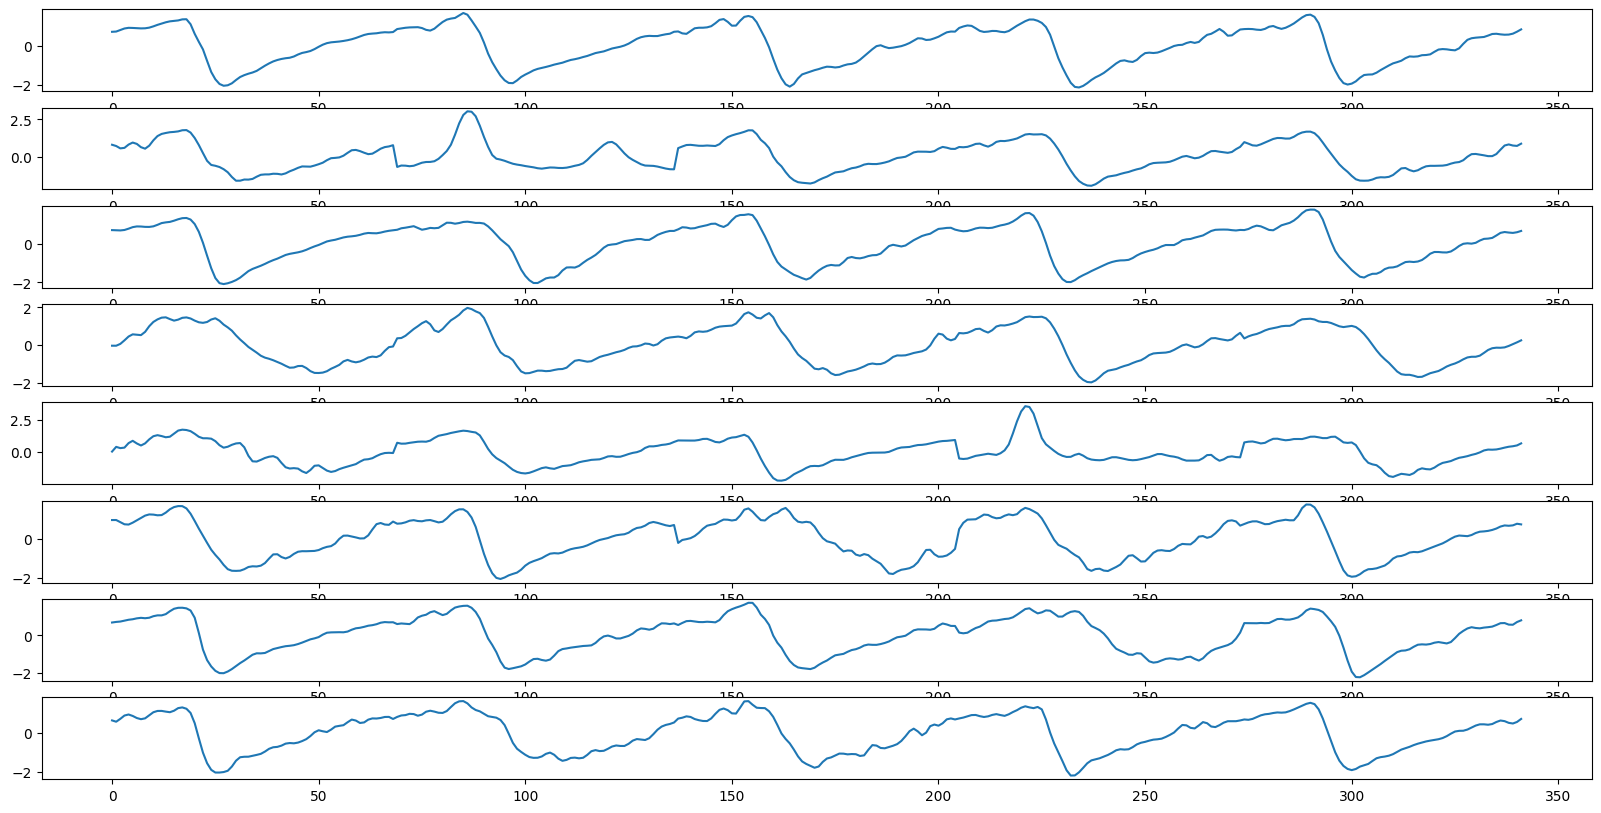

In [8]:
plt.figure(figsize=(20,10))
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class2[7][i])

### Training Parameter

In [9]:
# training parameter
device='cpu'
original_length = len(Class1[0][0])
num_classes = 2
batch_size = 32
original_dim = nb_dim

### Generate pyTorch-like datasets 

In [10]:
label = [1]*100 + [0]*100
label_test = [1]*24 + [0]*24

label = np.array(label)
label_test = np.array(label_test)

all_class = Class1[:100] + Class2[:100]
all_class_test = Class1[100:124] + Class2[100:124]


all_class = np.array([gen_cube(acl) for acl in all_class])
all_class_test = np.array([gen_cube(acl) for acl in all_class_test])

x = all_class
dataset_mat = TSDataset(x,label)
dataloader_cl1 = data.DataLoader(dataset_mat, batch_size=batch_size, shuffle=True)

x = all_class_test
dataset_mat_test = TSDataset(x,label_test)
dataloader_cl1_test = data.DataLoader(dataset_mat_test, batch_size=1, shuffle=True)

In [11]:
print(f"all_class shape: {all_class.shape} (samples: {all_class.shape[0]}, dims: {all_class.shape[1]}, cube dims: {all_class.shape[2]}, length: {all_class.shape[3]})")
print(f"all_class_test shape: {all_class_test.shape} (samples: {all_class_test.shape[0]}, dims: {all_class_test.shape[1]}, cube dims: {all_class_test.shape[2]}, length: {all_class_test.shape[3]})")

all_class shape: (200, 8, 8, 342) (samples: 200, dims: 8, cube dims: 8, length: 342)
all_class_test shape: (48, 8, 8, 342) (samples: 48, dims: 8, cube dims: 8, length: 342)


In [12]:
# Check the type of the dataset_mat object
print("Type of `dataset_mat`:", type(dataset_mat))
# Get a single instance (x1: data, y1: label) from the dataset
x1, y1 = next(iter(dataset_mat))
print("A single iteration over `dataset_mat` is a (D,D,N_samples) train instance:")
print("x1 shape:", x1.shape)  # Should be (8, 8, 342)
print("y1 label:", y1)

print("\nType of `dataloader_cl1`:", type(dataloader_cl1))
# Get a mini-batch (xb: batch data, yb: batch labels) from the dataloader
xb, yb = next(iter(dataloader_cl1))
print("A single iteration over `dataloader_cl1` is a (batch_size, 8, 8, 342) mini-batch instance:")
print("xb shape:", xb.shape)  # Should be (batch_size, 8, 8, 342)
print("yb shape:", yb.shape)  # Should be (batch_size,)

Type of `dataset_mat`: <class 'CNN_models.TSDataset'>
A single iteration over `dataset_mat` is a (D,D,N_samples) train instance:
x1 shape: (8, 8, 342)
y1 label: 1

Type of `dataloader_cl1`: <class 'torch.utils.data.dataloader.DataLoader'>
A single iteration over `dataloader_cl1` is a (batch_size, 8, 8, 342) mini-batch instance:
xb shape: torch.Size([32, 8, 8, 342])
yb shape: torch.Size([32])


# Training the model

Note that the usage of Batchnorm layer is not appropriate to all use cases. By expirience, this layer cause an instablility and a lower convergence is some of the use cases tested. It seems that this layer make some pertubation fail to be classified.

### Training the model

In [13]:
from torchsummary import summary

#dCNN
modelarch = ConvNet2D(original_length,original_dim,original_dim,num_classes).to(device)
#dResNet
#modelarch = dResNetBaseline(original_dim,mid_channels=128,num_pred_classes=num_classes).to(device)
#dInceptiontime
#modelarch = dInceptionModel(num_blocks=3, in_channels=original_dim, out_channels=64,
#                            bottleneck_channels=64, kernel_sizes=[10,20,40],
#                            use_residuals=True, num_pred_classes=num_classes).to(device)



model = ModelCNN(modelarch,device)

summary(model.model.to(device),input_size=(original_dim,original_dim,original_length), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 8, 342]           3,200
       BatchNorm2d-2          [-1, 128, 8, 342]             256
              ReLU-3          [-1, 128, 8, 342]               0
            Conv2d-4          [-1, 128, 8, 342]          49,280
       BatchNorm2d-5          [-1, 128, 8, 342]             256
              ReLU-6          [-1, 128, 8, 342]               0
            Conv2d-7          [-1, 256, 8, 342]          98,560
       BatchNorm2d-8          [-1, 256, 8, 342]             512
              ReLU-9          [-1, 256, 8, 342]               0
           Conv2d-10          [-1, 256, 8, 342]         196,864
      BatchNorm2d-11          [-1, 256, 8, 342]             512
             ReLU-12          [-1, 256, 8, 342]               0
           Conv2d-13          [-1, 256, 8, 342]         196,864
             ReLU-14          [-1, 256,

In [14]:
model.train(num_epochs=70,dataloader_cl1=dataloader_cl1,dataloader_cl1_test=dataloader_cl1_test)

Epoch [1/70], Loss Train: 0.6999,Loss Test: 0.6943, Accuracy Train: 50.00%, Accuracy Test: 50.00%
Epoch [11/70], Loss Train: 0.6577,Loss Test: 0.6548, Accuracy Train: 87.50%, Accuracy Test: 81.25%
Epoch [21/70], Loss Train: 0.5988,Loss Test: 0.5965, Accuracy Train: 93.00%, Accuracy Test: 89.58%
Epoch [31/70], Loss Train: 0.5136,Loss Test: 0.5114, Accuracy Train: 92.50%, Accuracy Test: 91.67%
Epoch [41/70], Loss Train: 0.4226,Loss Test: 0.4127, Accuracy Train: 96.00%, Accuracy Test: 93.75%
Epoch [51/70], Loss Train: 0.3197,Loss Test: 0.3254, Accuracy Train: 99.00%, Accuracy Test: 97.92%
Epoch [61/70], Loss Train: 0.2537,Loss Test: 0.2548, Accuracy Train: 98.50%, Accuracy Test: 97.92%


### Train and test loss (Binary Cross Entropy) versus Epoch  

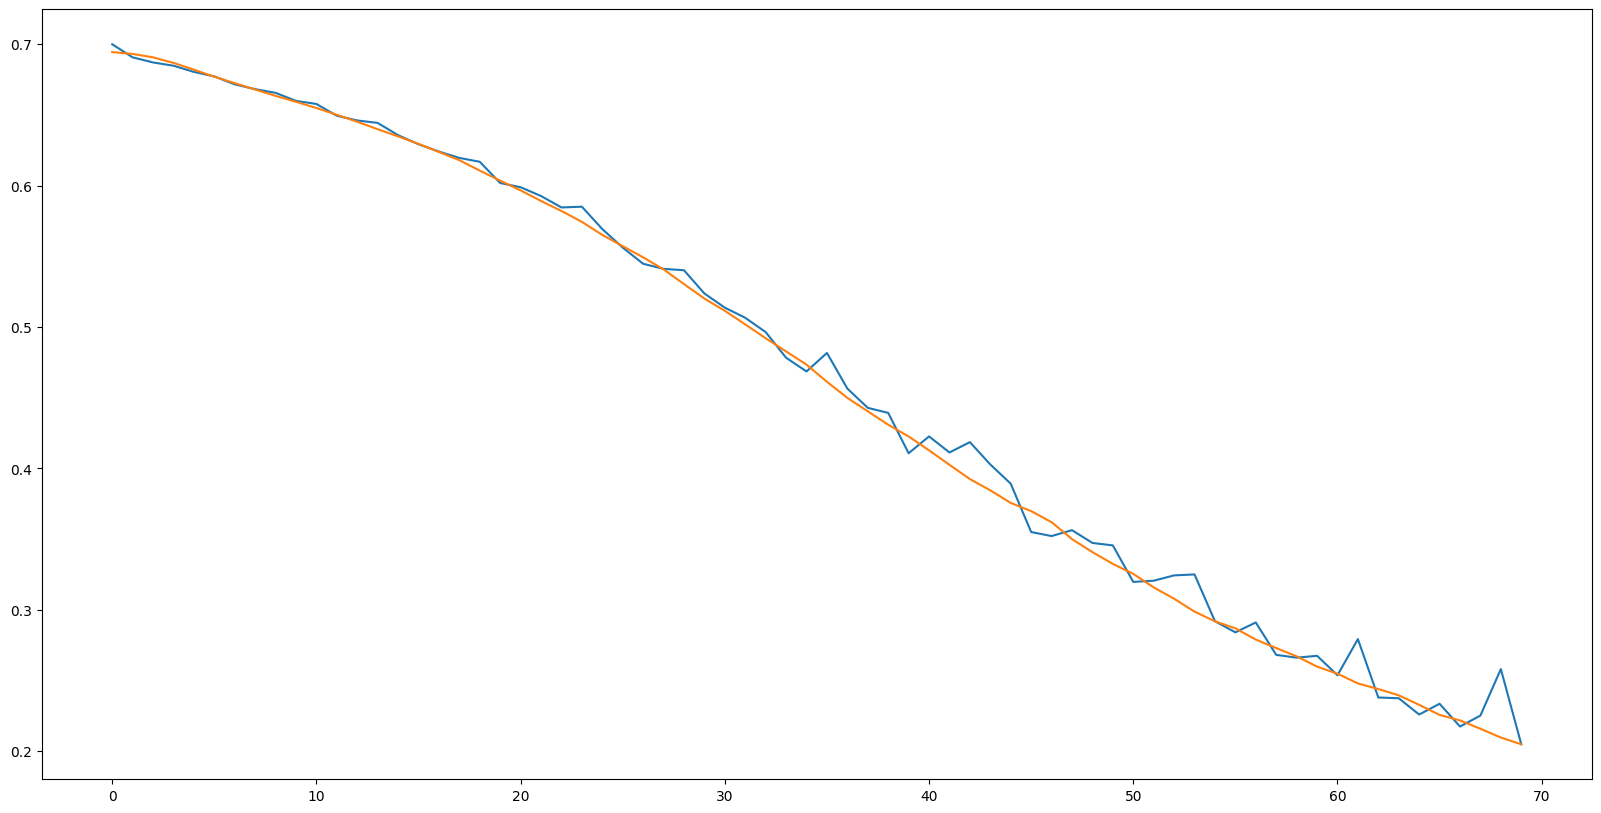

In [15]:
plt.figure(figsize=(20,10))
plt.plot(model.loss_train_history)
plt.plot(model.loss_test_history)

# d-CAM Class Activation Map


In [22]:
model = torch.load("model", map_location=device, weights_only=False).to(device)
model = model.eval()

instance = np.array(Class2[3])
label_instance = 0

instance_to_try = Variable(
    torch.tensor(
        instance.reshape(
            (1,1,original_dim,original_length))).float().to(device),
    requires_grad=True)


# dCNN
last_conv_layer = model._modules['layer3']
fc_layer_name = model._modules['fc1']

# dResNet
#last_conv_layer = model.model._modules['layers'][2]
#fc_layer_name = model.model._modules['final']

#InceptionTime
#last_conv_layer = model.model._modules['blocks'][2]
#fc_layer_name = model.model._modules['linear']



DCAM_m = DCAM(model,device,last_conv_layer=last_conv_layer,fc_layer_name=fc_layer_name)
dcam,permutation_success = DCAM_m.run(
    instance=instance,
    nb_permutation=200,
    label_instance=label_instance)

  0%|          | 0/200 [00:00<?, ?it/s]/home/tapyu/git/dCAM/examples/../src/explanation/DCAM.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()
100%|██████████| 200/200 [00:24<00:00,  8.23it/s]


dcam


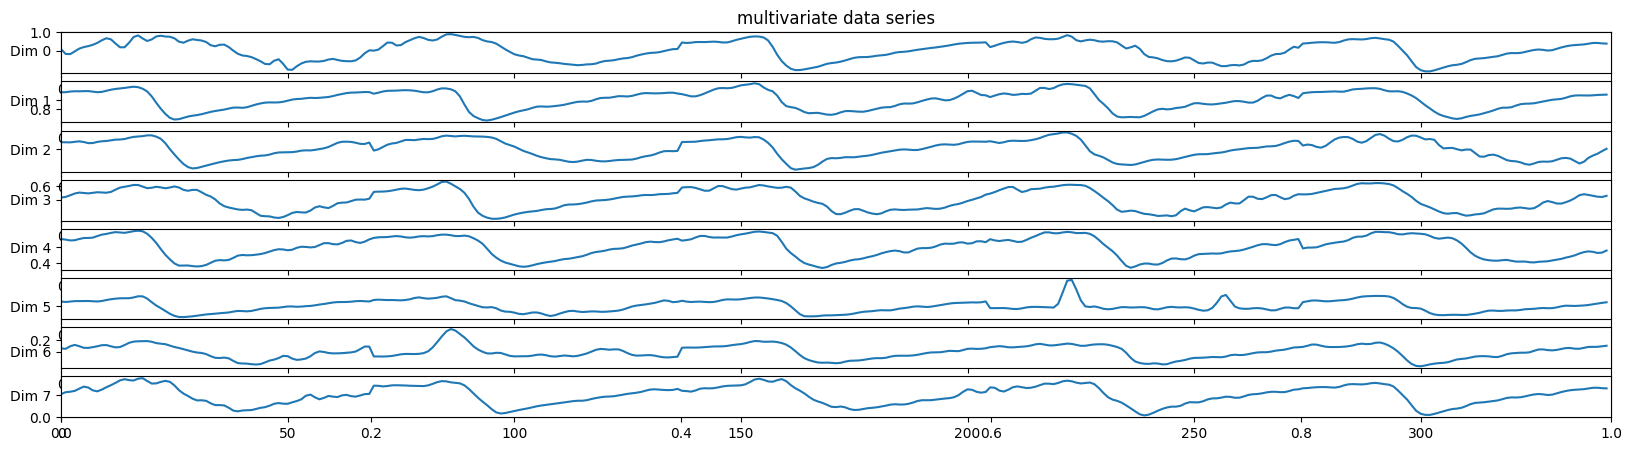

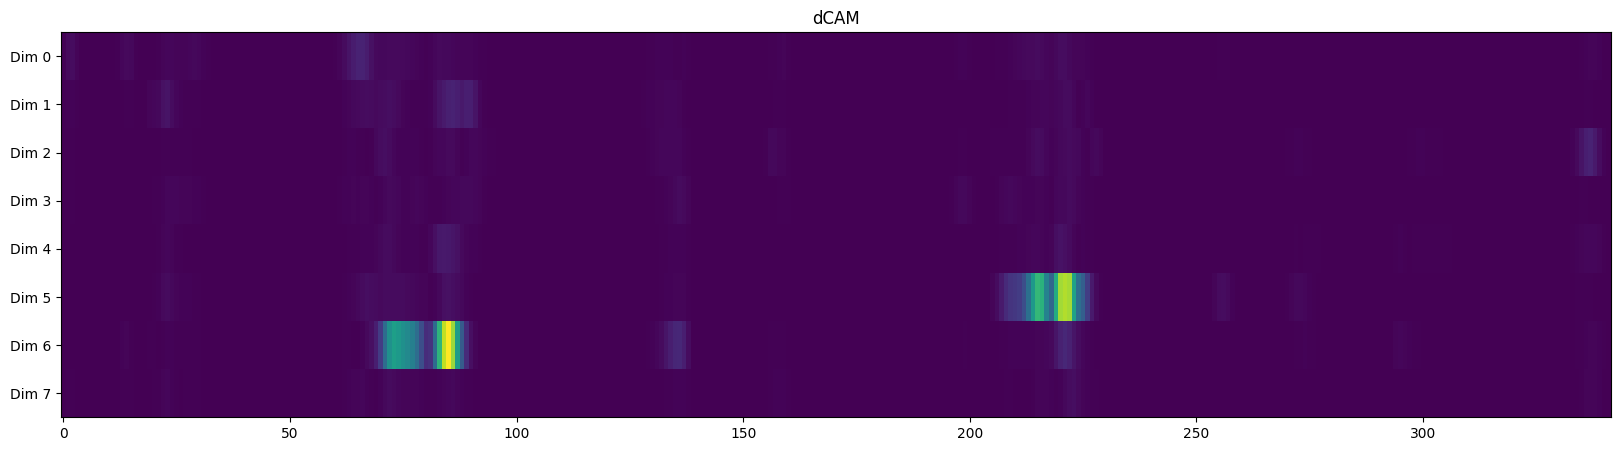

In [23]:
plt.figure(figsize=(20,5))
plt.title('multivariate data series')
for i in range(len(instance)):
    plt.subplot(len(instance),1,1+i)
    plt.plot(instance[i])
    plt.xlim(0,len(instance[i]))
    plt.yticks([0],["Dim {}".format(i)])

plt.figure(figsize=(20,5))
plt.title('dCAM')
plt.imshow(dcam,aspect='auto',interpolation=None)
plt.yticks(list(range(nb_dim)), ["Dim {}".format(i) for i in range(nb_dim)])
print('dcam')
#plt.colorbar(img)